# Implementing a Multilayer Artificial Neural Network from Sractch

## Introducting the multiplayer neural network architecture

We are going to start our exploration of Neural networks with a **M**ulti**L**ayer **P**erceptron (MLP). We'll use it to learn how to connect multiple single neurons. The following picture illustrates an MLP consisting of **three** layers:

![mlp](etc/mlp.png)

The above MLP has one:

- Input Layer (1st layer)
- Hidden Layer (2nd layer)
- Output Layer (3rd layer)

And notice, our MLP is **fully connected**. It means that each unit in the input layer is **connected to all** units in the hidden layer, and each units in the hidden layer is **connected to all** units in the output layer. If the network had _more than one_ hidden layer, we would call it a **deep artificial Neural Network (NN)**. And the field of **Deep Learning** is concerned with the development algorithm to help us train such structures.

Now, let's define how we will refer to elements in our neural network:

- We denote the $i^{th}$ activation unit in the $l^{th}$ layer: $a_i^{(l)}$
- We denote the connection between the $k^{th}$ unit in layer $l - 1$ to the $j^{th}$ unit in layer $l$ as: $w_{k,j}^{l}$

The book denotes the weight matrix that connects the input to the hidden layer as: **$W^{(h)}$** and the weight matrix that connects the hidden layer to the output layer as: **$W^{(out)}$**

---

Wait, what **Weight matrix?!**

Okay, let me walk you through how to derive $W^{(h)}$ and you can try to do the same for $W^{(out)}$

Let's say we have a data set of only **ONE** training example, and we want to "forward" propagate that one input from the input layer (in) to the hidden layer (h). To do that, we have to compute $a_1^{(h)}$, $a_2^{(h)}$, $\dots$, $a_d^{(h)}$. For instance,

$a_1^{(h)} = \phi(z_1^{(h)})$

$z_1^{(h)} = a_0^{(in)} w_{0,1}^{(h)} + a_1^{(in)} w_{1,1}^{(h)} + \dots + a_m^{(in)} w_{m,1}^{(h)}$

Now consider the following matrix for $z^{(h)}$

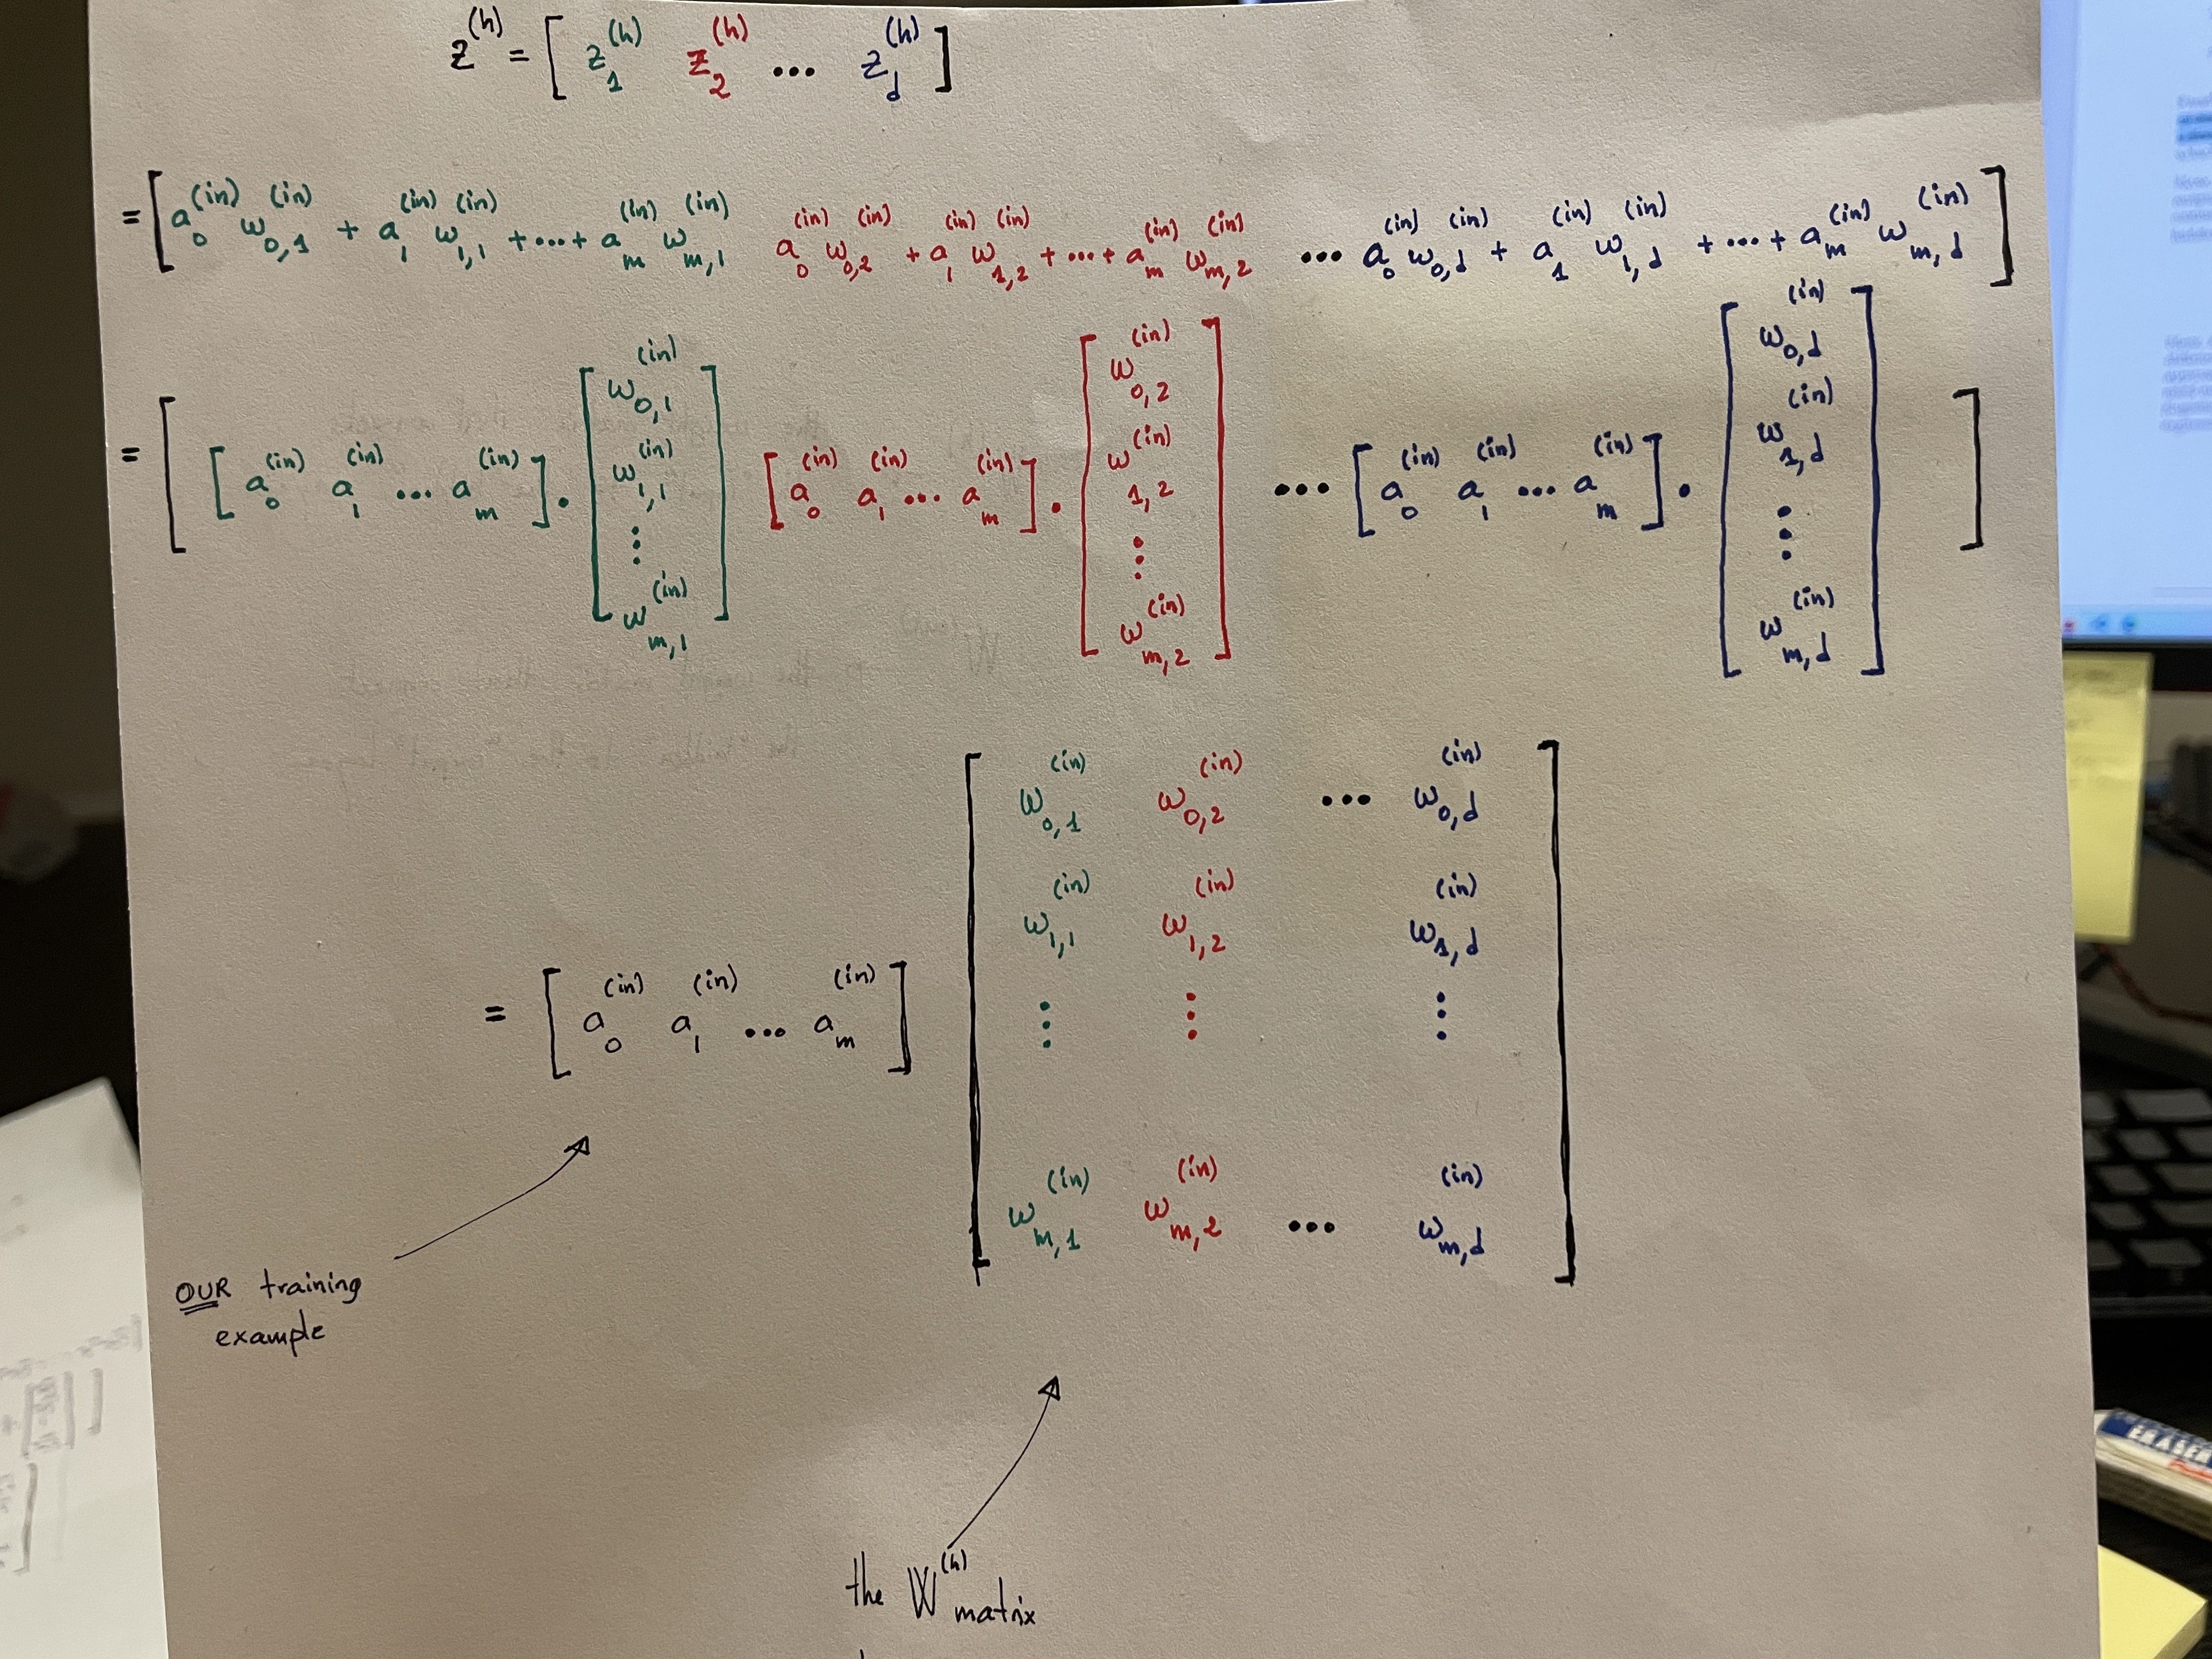

Notice, the weight matrix $W^{(h)}$ is an $m \times d$ matrix where $d$ is the number of units in the hidden layer and $m$ is the number of units in the input layer, including the bias unit.

As you can see, our training example is being multiplied by that weight matrix, to compute its net input vector $Z^{(h)}$.

$Z^{(h)} = a^{(in)}W^{(h)}$

$a^{(h)} = \phi(Z^{(h)})$

Here $a^{(in)}$, is our training example (an $1 \times m$ matrix). And since $W^{(h)}$ is an $m \times d$ matrix, the resulting net input vector $Z^{(h)}$ is an $1 \times d$ row matrix. That net input vector is then passed to the activation function to compute $a^{(h)}$ which is $1 \times d$ matrix. Now, we can generalize this computation to all $n$ example in the training dataset:

$Z^{(h)} = A^{(in)}W^{(h)}$. Here, $A^{(in)}$ is an $n \times m$ matrix.

**Each** training example (row) in the matrix is multiplied by the weight matrix. This multiplication happens through the matrix-matrix multiplication of $A^{(in)}$ and $W^{(h)}$ because each row of $A^{(in)}$ gets multiplied to $W^{(h)}$. 

This matrix-matrix multiplication results in an $n \times d$, net input matrix $Z^{(h)}$; where the $i^{(th)}$ row in $Z^{(h)}$ is the result of the matrix-vector multiplication of the $i^{(th)}$ training example and the weight matrix.

Finally, we apply the function $\phi(\bullet)$ to each value in the net input matrix to get the $n \times d$ **activation** matrix. 

$A^{(h)} = \phi(Z^{(h)})$

The $i^{(th)}$ row in the activation matrix contains the values the activation units in the hidden layer will contains after the $i^{th}$ training example forward propagates :)

Similarly, we can write the activation of the **output layer** in vectorized form for multiple examples:

$Z^{(out)} = A^{(h)}W^{(out)}$ and $A^{(out)} = \phi(Z^{(out)})$ where $A^{(out)}$ is an $n \times t$ matrix.

**Challenge**: Can you see why? Can you derive $W^{(out)}$?

---

Ok, cool. But why did we use those matrices?

For code effeciency and readability. We used our basic linear algebra skills to write the computations in a more compact way, so we do not use computationally expensive Python `for` loops. It also helps us delegate those computations to a GPU.

## Classifying handwritten digits

Let's implement and train our first multilayer NN to classify handwritten digits.

### Obtaining and preparing the MINIST dataset

The dataset is freely available on [Yann Lecun's website](http://yann.lecun.com/exdb/mnist/). It consists of the following four parts:

1. **Training dataset images**: train-images-idx3-ubyte.gz (60,000 examples)
2. **Training dataset labels**: train-labels-idx1-ubyte.gz (60,000 labels)
3. **Test dataset images**: t10k-images-idx3-ubyte.gz (10,000 examples)
4. **Test dataset labels**: t10k-labels-idx1-ubyte.gz (10,000 labels)

Each part is in its own archive file, and must be unzipped.

With the dataset unzipped, we need to read the images and the labels into NumPy arrays. Both are stored as _binary_ files. We acheive this using the `load_mnist` function.

In [2]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST dataset from 'path' """
    
    images_path = os.path.join(path, '%s-images-idx3-ubyte' %kind) #Notice, it is a formatted string
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' %kind)
    
    #Read in the labels
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8)) #Read the first 64 bits (8 bytes)
        labels = np.fromfile(lbpath, dtype=np.uint8) # Construct array from Reading bytes one at a time
        
    #Read in the images
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784) #Read all the pixels into ONE large array, then reshape it into a 60,000 x 784 matrix
        images = ((images / 255.) - 0.5) * 2 #Normalize pixels between -1 to 1
        
    
    return images, labels

It is common practice to have pixels fall in the $[-1, 1]$ range and centered at 0. It usually works well in practice, Sebastian Raschka says in his Python Machine Learning book.

With the `load_mnist` helper written, let's load the MNNIST dataset. In my case, the MNIST dataset is within the `dataset` folder which I added to my `.gitignore` file

In [3]:
#X_train = the training set, 
#y_train = label for each training example in X_train
X_train, y_train = load_mnist('./dataset', kind='train')

#X_train dimensions
print('Rows: %d, Columns: %d' %(X_train.shape[0], X_train.shape[1]))

Rows: 60000, Columns: 784


In [4]:
#X_test = the testing set (part of the dataset set aside to test the NN)
#y_test = label for each training example in X_test
X_test, y_test = load_mnist('./dataset', kind='t10k')

#X_test dimensions
print('Rows: %d, Columns: %d' %(X_test.shape[0], X_test.shape[1]))

Rows: 10000, Columns: 784


As we can see, the training set and the testing set contain 60,000 and 10,000 examples respectively. And each example has 784 features, where each feature is a pixel :). Since we are dealing with $28 \times 28$ images, we have $784$ pixels in total.

Let's plot some of the images using the Matplotlib's `imgshow` function

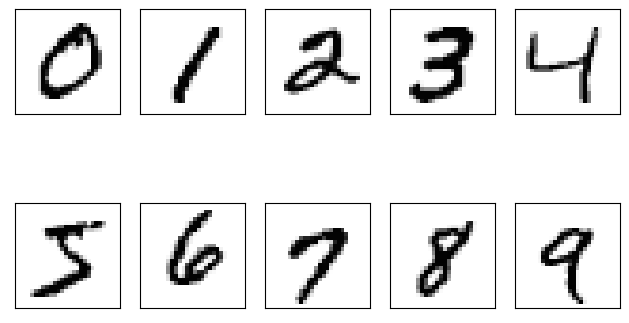

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5,
                     sharex=True, sharey=True)

ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Cool, right !? Let's move on

Those NumPy arrays are big. At least, from the eyes of a begineer like me. Surely, there should be a way to compress and store those arrays so we avoid the overhead of reading and processing the data over and over.

To achieve that, NumPy provides a function called `savez_compressed`. It saves several arrays into a single in compressed `.npz` format.

In [6]:
np.savez_compressed('mnist_scaled.npz',
                   X_train=X_train,
                   y_train=y_train,
                   X_test=X_test,
                   y_test=y_test)

After we create the `.npz` file, we can read it and load the preprocessed MNIST images using NumPy's `load` function. It goes like this:

In [7]:
mnist = np.load('mnist_scaled.npz')

The `load` function returns an object with some attributes, "**files**" is one of them. The "files" attribute returns a list of the objects inside. It goes like this:

In [8]:
print(mnist.files)

['X_train', 'y_train', 'X_test', 'y_test']


Let's do a recap of what happened so far because what will follow is new and important for me:

1. We downloaded the MNIST dataset. It's a 4-part dataset
2. We unzipped the archives
3. Read the dataset into Numpy arrays using the `load_mnist` helper we wrote
4. We compressed the NumPy arrays using the `savez_compressed` function

Now, let's implement our MLP to classify those handwritten digits. This is what we are here for, right? So, buckle up 😊🚀

### Implementing a multilayer perceptron

In [9]:
import sys

class NeuralNetMLP(object):
    """Feedforward neural network / Multi-layer perceptron classifier
    
    Parameters
    -----------
    n_hidden : int (default: 30)
        Number of hidden units
    
    l2 : float (default: 0.)
        Lambda value for L2-regularization
        No regularization if l2=0. (default)
    
    epochs : int (default: 100)
        Number of passes over the training set
        
    eta : float (default: 0.001)
        Learning rate
        
    shuffle: bool (default: True)
        Shuffles training data every epoch if "True" to prevent cycles
        
    minibatch_size : int (default: 1)
        Number of training examples per batch. The number of training
        examples to process before updating the weight. Remember the
        definiton of "batch"
        
    seed : int (default: None)
        Random seed for initializing weights and shuffling
        
    
    Attributes
    ------------
    eval_ : dict
        Dictionary of three arrays collecting the cost, training accuracy,
        and validation accuracy (respectively) for each epoch during training
    """
    
    def __init__(self, n_hidden=30, l2=0.,
                 epochs=100, eta=0.001, shuffle=True, minibatch_size=1, seed=None):
        
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _oneshot(self, y, n_labels):
        """Encode labels into one-hot representation
        
        Parameters
        -----------
        y: array, shape = [n_examples]
            Target values.
        
        n_labels: int
            Number of labels. In our case, 10.
            
        Returns
        ----------
        oneshot: array, shape = (n_examples, n_labels)
        """
        
        onehot = np.zeros((n_labels, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1
        
        return onehot.T
    
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        """Compute forward propagation from input to output layer"""
        
        #1- Forward propagate from INPUT to HIDDEN layer
        # "Training matrix" times "weight matrix"
        # [n_examples, n_features] dot [n_features, n_hidden] -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
        
        #2- Apply activation function to hidden layer
        a_h = self._sigmoid(z_h)
        
        #3- Forward propagate from HIDDEN to OUTPUT layer
        #[n_examples, n_hidden] dot [n_hidden, n_classlabels] -> [n_examples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
        
        #4- Apply activation function to output layer
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        """Compute cost function
        
        Parameters
        ------------
        y_enc: array, shape = (n_examples, n_labels)
            one-hot encoded class labels
            
        output: array, shape = [n_examples, n_output_units]
            Activation of the output layer. Results from forward propagating from hidden to output layer
            
        Returns
        ----------
        cost : float
            Regularized cost
        """
        L2_term = (self.l2 * 
                   (np.sum(self.w_h ** 2.0) +
                    np.sum(self.w_out ** 2.0)))
        
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2) + L2_term
        
        return cost
    
    def predict(self, X):
        """Predict class labels
        
        Parameters
        ------------
        X : array, shape = [n_examples, n_features]
            Training set
        
        Returns
        ------------
        y_pred : array, shape = [n_examples]
            Predicted class labels
        """
        
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data
        
        Parameters
        ------------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features. It's our training set :)
        y_train : array, shape = [n_examples]
            Target class labels for each training example
        X_valid : array, shape = [n_examples, n_features]
            Part of the training set used for validation during training
        y_valid : array, shape = [n_examples]
            Target class labels for each training examples used for validation during training
        
        Returns
        ------------
        self
        
        """
        n_output = np.unique(y_train).shape[0] # no. of class labels. 10 in our case
        n_features = X_train.shape[1] #784 features for each training example
        
        ########################
        # Weight initialization
        ########################
        
        #1- Weight matrix from input -> hidden layer
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        
        #2- Weight matrix from hidden -> output layer
        self.b_out = np.zeros(self.n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
        
        ########################
        # Some setup before training
        ########################
        
        #1- for progr. format.
        epoch_strlen = len(str(self.epochs))
        
        #2- collects the "cost", "training", and "validation" accuracy for each epoch
        self.eval_ = {
            'cost': [],
            'train_acc': [],
            'valid_acc': []
        }
        
        #3- Hot encode training labels. Returns a "n" x 10 matrix
        y_train_enc = self._oneshot(y_train, n_output)
        
        ########################
        # Now training
        ########################